In [ ]:
import warnings, os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from climakitae.core.data_interface import get_data

warnings.filterwarnings("ignore")

STANDARD_CRS = "EPSG:4326"
METRIC_CRS = "EPSG:3310"
PARK_NAME = "Mojave National Preserve"
SHAPEFILE = "../data/Mojave_National_Preserve.shp"
BUFFER_KM = 5

SCENARIOS = ["Historical Climate","SSP 2-4.5","SSP 3-7.0","SSP 5-8.5"]
METHOD = "Dynamical"
RES = "3 km"
TIME_SLICE = (1980, 2100)

BASELINE = (1995, 2014)
FUTURE = (2070, 2099)

COLORS = {
    "Historical Climate": "#8fbbe8",
    "SSP 2-4.5": "#6ea0ff",
    "SSP 3-7.0": "#3b348b",
    "SSP 5-8.5": "#a34b4b"
}


In [25]:
def load_boundary(shp_path, buffer_km):
    gdf = gpd.read_file(shp_path)
    if gdf.crs is None:
        gdf = gdf.set_crs(STANDARD_CRS)
    gdf_m = gdf.to_crs(METRIC_CRS)
    gdf_buf_m = gdf_m.buffer(buffer_km*1000).to_frame("geometry")
    gdf_buf = gdf_buf_m.set_crs(METRIC_CRS).to_crs(STANDARD_CRS)
    gdf_buf = gpd.GeoDataFrame(geometry=gdf_buf.geometry)
    bounds = gdf_buf.total_bounds
    lon_slice = (float(bounds[0]), float(bounds[2]))
    lat_slice = (float(bounds[1]), float(bounds[3]))
    return gdf_buf, lat_slice, lon_slice

boundary_wgs84, LAT_SLICE, LON_SLICE = load_boundary(SHAPEFILE, BUFFER_KM)

In [26]:
def ensure_celsius(da):
    if da.attrs.get("units","").lower().startswith("k"):
        da = da - 273.15
        da.attrs["units"] = "°C"
    return da

def mask_to_boundary(da, boundary_gdf_wgs84):
    if da is None:
        return None
    try:
        data_crs = da.rio.crs
    except Exception:
        data_crs = None
    if data_crs is None:
        try:
            da = da.rio.write_crs(STANDARD_CRS, inplace=False)
            data_crs = da.rio.crs
        except Exception:
            return da
    b_native = boundary_gdf_wgs84.to_crs(data_crs)
    try:
        coords_to_drop = ["lat","lon","landmask","lakemask"]
        da_clean = da.drop_vars(coords_to_drop, errors="ignore")
    except Exception:
        da_clean = da
    try:
        ydim, xdim = da_clean.rio.y_dim, da_clean.rio.x_dim
    except Exception:
        if "y" in da_clean.dims and "x" in da_clean.dims:
            ydim, xdim = "y","x"
        else:
            return da
    non_spatial = [d for d in da_clean.dims if d not in (ydim, xdim)]
    order = tuple(non_spatial+[ydim, xdim])
    if tuple(da_clean.dims) != order:
        da_clean = da_clean.transpose(*order)
    clipped = da_clean.rio.clip(b_native.geometry.values, drop=False, all_touched=True)
    try:
        spatial_mean = clipped.mean(dim=[ydim, xdim], skipna=True)
    except Exception:
        spatial_mean = da.mean(dim=["x","y"], skipna=True)
    return spatial_mean

def fetch_box(variable, scenario):
    ds = get_data(
        variable=variable,
        downscaling_method=METHOD,
        resolution=RES,
        timescale="monthly",
        scenario=scenario,
        time_slice=TIME_SLICE,
        latitude=LAT_SLICE,
        longitude=LON_SLICE
    )
    if ds is None or getattr(ds,"time",None) is None or ds.time.size==0:
        return None
    da = ds[list(ds.data_vars)[0]] if isinstance(ds, xr.Dataset) else ds
    da = ensure_celsius(da)
    da_box = mask_to_boundary(da, boundary_wgs84)
    return da_box


In [27]:
def seasonal_30yrs(da, y0, y1):
    win = da.sel(time=slice(f"{y0}-01-01", f"{y1}-12-31"))
    if getattr(win,"time",None) is None or win.time.size==0:
        return None, None
    monthly = win.groupby("time.month").mean("time")
    if "simulation" in monthly.dims:
        m = monthly.mean("simulation")
        s = monthly.std("simulation")
    else:
        m = monthly
        s = xr.zeros_like(monthly)
    mo = np.arange(1,13)
    return np.ravel(m.sel(month=mo).values), np.ravel(s.sel(month=mo).values)


ERROR: No data found for your input values. Please modify your data request. 
Returning None
ERROR: No data found for your input values. Please modify your data request. 
Returning None


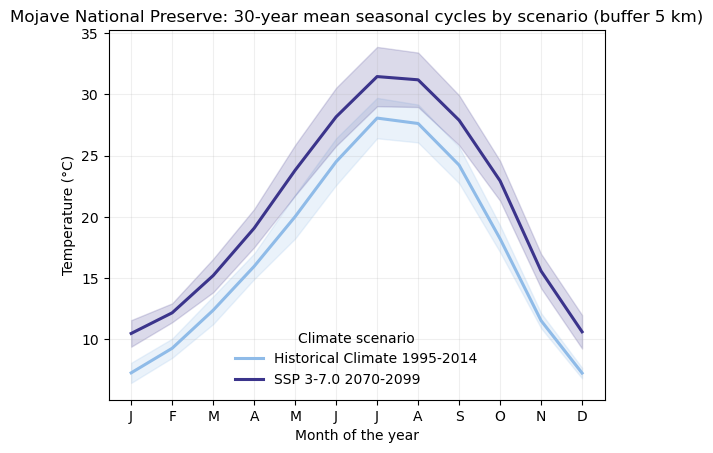

In [28]:
curves = []
for scen in SCENARIOS:
    da = fetch_box("Air Temperature at 2m", scen)
    if da is None:
        continue
    if scen == "Historical Climate":
        mean_vals, std_vals = seasonal_30yrs(da, *BASELINE)
        if mean_vals is not None:
            curves.append((f"{scen} {BASELINE[0]}-{BASELINE[1]}", scen, mean_vals, std_vals))
    else:
        mean_vals, std_vals = seasonal_30yrs(da, *FUTURE)
        if mean_vals is not None:
            curves.append((f"{scen} {FUTURE[0]}-{FUTURE[1]}", scen, mean_vals, std_vals))

months = np.arange(1,13)
fig, ax = plt.subplots()
for label, scen_key, m, s in curves:
    c = COLORS.get(scen_key, None)
    ax.plot(months, m, label=label, linewidth=2.2, color=c)
    ax.fill_between(months, m-s, m+s, alpha=0.18, color=c)
ax.set_xticks(months)
ax.set_xticklabels(list("JFMAMJJASOND"))
ax.set_xlabel("Month of the year")
ax.set_ylabel("Temperature (°C)")
ax.set_title(f"{PARK_NAME}: 30-year mean seasonal cycles by scenario (buffer {BUFFER_KM} km)")
ax.legend(title="Climate scenario", frameon=False)
ax.grid(alpha=0.2)
plt.show()
